## Elementary Examples in Inverse Dynamics

Falk Mielke, FunMorph, Universiteit Antwerpen

You can download this notebook [here](user://notebooks/ID_LMX3_Slider.ipynb?download&target=_blank).

This is one part of a series of blog posts on Inverse Dynamics.
- [Prologue A: Wrench Town Rock](../id_lmx0a_wrenches)
- [Prologue B: The Fictitious Force Awakens](../id_lmx0b_fforces)
- [Elementary Example 1: Stuttering Motor (Euler Force)](../id_lmx1_stutter)
- [Elementary Example 2: Needle On A Vinyl (Centrifugal Force)](../id_lmx2_vinyl)
- [Elementary Example 3: Radial Slider (Coriolis Force)](../id_lmx3_slider)
- [Application: N-Link Inverse Dynamics](../id_lmx4_nlink)

In [1]:
import numpy as NP # numerics
import sympy as SYM # symbolic operations
import sympy.physics.mechanics as MECH # some physics/mechanics tools
import matplotlib.pyplot as MPP # plotting

import WrenchToolbox as WT # contains an improved "Wrench" object

# printing of formulas
SYM.init_printing(use_latex='mathjax', pretty_print = False)
MECH.init_vprinting(use_latex='mathjax', pretty_print = False)


# shorthand to get the basis of a reference frame
GetCoordinates = lambda rf: [rf[idx] for idx in rf.indices]

# transforming a sympy vector to a matrix
MatrixToVector = lambda mat, rf: sum([elm * base for elm, base in zip(mat, GetCoordinates(rf)) ])


# Steiner's Theorem, generalized form 
# [modern robotics, page 245]
GeneralizedSteiner = lambda mass, columnvector: \
                        SYM.simplify( \
                             mass * ( (columnvector.T*columnvector)[0] * SYM.eye(3) \
                                      - columnvector*columnvector.T \
                                    ) \
                             )

The custom Wrench Toolbox [can be downloaded here.](http://mielke-bio.info/share/WrenchToolbox.py?download&target=_blank)

# Elementary Example 3: A Radial Slider

Ultimately, we want to study inverse dynamics of limbs. 
The previous notebooks covered two fictitious forces, and also touched on the mysterious Coriolis force. 
And still, we are not even close to limbs.

This feeling of "not quite being there yet" has followed my supervisors and me for two months now. 
My promotor Peter even climbed his attic to find his 35 year old notes from a biomechanics lecture. 
I appreciate their dedication and commitment, and their will to learn, and would therefore like to dedicate this notebook to my patient supervisors. 

Here's our setting for this notebook, which I found [on a great physics website](https://www.real-world-physics-problems.com/coriolis-force.html?target=_blank):

<img src="images/id_lmx_3.svg" width="500px"> </img>


We use the famiiar rotating reference frame from previous situations. 
However, this time, the point mass is not fixed in place, but moving outwards with increasing velocity. 
Despite this movement, it always stays at an angle $\varphi$.

# Initialization

Besides the time-dependent rotational angle $\varphi(t)$, which is set up as usual, I will use a $\gamma$ function to describe the time-dependent position of the point mass in the reference frame. 
I intended to let the point mass slide out with just exactly the centrifugal acceleration, so that there would be no force resisiting the outward pull. 
But that seems to be a non-trivial setting (involves a differential equation), at least I failed to find good specifications. 

So you will find a very simple specification, $\gamma = t^2$.
We can learn a lot anyways.

In [2]:
# time, length, mass, gravitational acceleration
t, l0, m = SYM.symbols('t, l0, m', real = True)

# set the period of rotation
period = SYM.symbols('T', real = True)

# this defines the angular velocity by 2π/T
φdot = 2.*SYM.pi/period

# the angle φ is a function of time
φ = SYM.Function('φ')(t)

# the angular velocity is equal to the first derivative of the angle
φ_function = SYM.integrate(φdot, t)

# this describes the way that the point mass is moving radially outwards:
γ = SYM.Function('γ')(t)
γ_funtion = t**2 # feel free to try out different functions here.

# we will store this for substitution later, 
# for being able to calculate with angles, and then break it down to time.
substitutes = {φ: φ_function, γ: γ_funtion}

substitutes

{γ: t**2, φ: 2.0*pi*t/T}

In [3]:
constants = {  m: 1. # kg \
             , l0: 0.1 # m \
             , period: 2.*SYM.pi # s \
             , SYM.pi: NP.pi # = 3.0 \
            }

# this function will substitute and simplify
PlugAllIn = lambda expression: SYM.simplify(SYM.nsimplify(SYM.simplify( \
                                  expression.subs(substitutes).doit().subs(constants).subs(constants) \
                                )))


# Reference Frames

There is nothing new here.

In [4]:
world = MECH.ReferenceFrame('S')

# initialize the {B} frame as rotated relative to the world by φ around the world's z axis.
body = world.orientnew('B', 'Axis', (φ, world.z))

# we give the body frame angular velocity and acceleration
body.set_ang_vel(world, φdot*world.z)
body.set_ang_acc(world, φdot.diff(t)*world.z) # should be zero in our case

body.ang_acc_in(world).to_matrix(world).T

Matrix([[0, 0, 0]])

In [5]:
# prepare a list of (label/frame) tuples.
frames = [('S', world), ('B', body)]

# "trafo" dict will store transformation matrices "to" any frame "from" another frame.
trafo = {label: {} for label, _ in frames}
for label_from, frame_from in frames:
    for label_to, frame_to in frames:
        trafo[label_to][label_from] = SYM.simplify(frame_to.dcm(frame_from))

# display example
PlugAllIn(trafo['S']['B'])

Matrix([
[cos(t), -sin(t), 0],
[sin(t),  cos(t), 0],
[     0,       0, 1]])

# Points

In [6]:
### define the origin
origin = MECH.Point('O')

# the origin does never move
origin.set_vel(world, 0)
origin.set_acc(world, 0)


### define joint
joint = MECH.Point('J')

## set position of joint
joint.set_pos(origin, sum([0*n for n in GetCoordinates(world)]))

## set position derivatives
# (i) in the body frame
joint.set_vel(body, 0)
joint.set_acc(body, 0)

# (ii) in the static frame
joint.set_vel(world, joint.pos_from(origin).diff(t, world).simplify())
joint.set_acc(world, joint.vel(world).diff(t, world).simplify())


Here the important change: the sliding point mass gets the gamma function as input.

In [7]:

### a point mass at a height above the joint
pointmass = MECH.Point('C')

# iteratively initialize pointmass
pointmass.set_pos(joint, γ * body.y)
    
# points do not move relative to the body frame
pointmass.set_vel(body, pointmass.pos_from(joint).diff(t, body).simplify())
pointmass.set_acc(body, pointmass.vel(body).diff(t, body).simplify())

# set velocity/acceleration of point in static rf
pointmass.set_vel(world, pointmass.pos_from(origin).diff(t, world).simplify())
pointmass.set_acc(world, pointmass.vel(world).diff(t, world).simplify())

    
# print the point accelerations
SYM.pprint(PlugAllIn(pointmass.pos_from(origin).subs(substitutes).express(world).to_matrix(world)).T)
SYM.pprint(PlugAllIn(pointmass.vel(world).express(world).to_matrix(world)).T)

⎡  2          2          ⎤
⎣-t ⋅sin(t)  t ⋅cos(t)  0⎦
[-t⋅(t⋅cos(t) + 2⋅sin(t))  t⋅(-t⋅sin(t) + 2⋅cos(t))  0]


# Inertial Properties
As usual.

In [8]:
# zero inertia relative to the com (because we have point masses)
inertia = MECH.inertia(body, 0, 0, 0)

I_B = {}
# the system has an inertia relative to the origin, which coincides with the center of mass.
for pt, refpoint in [('P', pointmass), ('J', joint), ('O', origin)]:
    I_B[pt] = inertia.to_matrix(body)\
                + GeneralizedSteiner(  m, pointmass.pos_from(refpoint).express(body).to_matrix(body) ) 


# all the I's can be transformed to the inertial reference frame
I_S = {}
for refpoint in I_B.keys():
    I_S[refpoint] = SYM.simplify(trafo['S']['B'] * I_B[refpoint] )

# print an example
PlugAllIn(I_S['O'])

Matrix([
[t**4*cos(t), 0,    0],
[t**4*sin(t), 0,    0],
[          0, 0, t**4]])

# Kinematics

I didn't count how often I copy-pasted this code.

In [9]:
# shorthands for the derivative levels
p = 0 # zero'th derivative: the position vector
v = 1 # first derivative: the velocity
a = 2 # second derivative: the acceleration

In [10]:
# prepare an empty dictionary
x = {}

# start with the position vectors
x['S'] = {pt: [pointmass.pos_from(refpoint).express(world).to_matrix(world)] \
          for pt, refpoint in [('O', origin), ('J', joint), ('P', pointmass)] \
         }
x['B'] = {pt: [pointmass.pos_from(refpoint).express(body).to_matrix(body)] \
          for pt, refpoint in [('O', origin), ('J', joint), ('P', pointmass)] \
         }

# automatically get time derivatives, in loops
# loop reference frames
for frame in x.keys():
    # loop reference points
    for refpoint in x[frame].keys():
        # loop differentials
        for diff_nr in range(2): 
            x[frame][refpoint].append(SYM.simplify(x[frame][refpoint][-1].diff(t)))


# Recall, the time derivatives depend on reference frame
SYM.pprint(PlugAllIn(x['B']['O'][v]).T)
SYM.pprint(PlugAllIn(trafo['B']['S']*x['S']['O'][v]).T)

[0  2⋅t  0]
⎡  2        ⎤
⎣-t   2⋅t  0⎦


Angular kinematics:

In [11]:
# the same dictionary magic as above
ω = {}

# angular positions
ω['S'] = [SYM.Matrix([[0],[0],[φ]])]
ω['B'] = [SYM.Matrix([[0],[0],[0]])]

# time derivatives
for frame in ω.keys():
    for diff_nr in range(2): 
        ω[frame].append(SYM.simplify(ω[frame][-1].diff(t)))

# quick check:
SYM.pprint(PlugAllIn(ω['S'][v] - body.ang_vel_in(world).to_matrix(world)).T)
SYM.pprint(PlugAllIn(ω['B'][v] - body.ang_vel_in(body).to_matrix(body)).T)

[0  0  0]
[0  0  0]


# Visualization

Minor modifications here, but as usual, quite reusable.

In [12]:
time = NP.linspace(0., 2*NP.pi, 128, endpoint = False)
position = SYM.lambdify(t, PlugAllIn(x['S']['O'][0]), 'numpy')
gamma = SYM.lambdify(t, PlugAllIn(γ_funtion), 'numpy')
lin_velocity = SYM.lambdify(t, PlugAllIn(x['S']['O'][1]), 'numpy')
lin_acceleration = SYM.lambdify(t, PlugAllIn(x['S']['O'][2]), 'numpy')
ang_velocity = SYM.lambdify(t, PlugAllIn(ω['S'][1]), 'numpy')
ang_acceleration = SYM.lambdify(t, PlugAllIn(ω['S'][2]), 'numpy')

In [13]:
y = [pos[0] for pos in position(time)] 

v_values = lin_velocity(time)


# arrange in arrays of equal lengths
for v_nr, val in enumerate(v_values):
    if (len(val) == 1) and NP.all(NP.sum(NP.abs(val)) == 0):
        v_values[v_nr] = [NP.zeros((len(time),))]
        
# stack velocities
vel = NP.stack([val[0] for val in v_values], axis = 1)

# get a color from v magnitude
v_mag = NP.sqrt(NP.sum(NP.power(vel, 2), axis = 1))
v_cval = v_mag - NP.min(v_mag)

# MPP.plot(time, v_cval);
# MPP.show()

<lambdifygenerated-1>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return (array([[-t**2*sin(t)], [t**2*cos(t)], [0]]))
<lambdifygenerated-3>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return (array([[-t*(t*cos(t) + 2*sin(t))], [t*(-t*sin(t) + 2*cos(t))], [0]]))


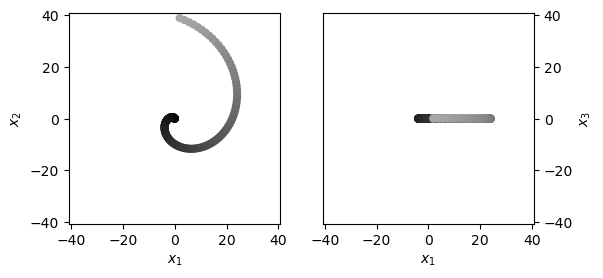

In [14]:
y = [pos[0] for pos in position(time)] 


fig = MPP.figure(dpi = 100)

ax = fig.add_subplot(1,2,1,aspect = 'equal')
ax.scatter(y[0], y[1], s = 24 \
           , color = [(val, val, val) for val in 0.66*v_cval/NP.max(v_cval)] \
           , marker = 'o' \
           , alpha = 1. \
          )
ax.set_xlim(NP.array([-1.05,1.05])*(gamma(NP.max(time))))
ax.set_ylim(NP.array([-1.05,1.05])*(gamma(NP.max(time))))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(1,2,2,aspect = 'equal')
ax.scatter(y[0], NP.ones((len(y[0]),))*y[2], s = 24 \
           , color = [(val, val, val) for val in 0.66*v_cval/NP.max(v_cval)] \
           , marker = 'o' \
           , alpha = 1. \
          )
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_xlim(NP.array([-1.05,1.05])*(gamma(NP.max(time))))
ax.set_ylim(NP.array([-1.05,1.05])*(gamma(NP.max(time))))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_3$')

MPP.show();

I really enjoy the visualization step.

# Fictitious Forces

Here is what we would expect for the **Euler Force,**

$F_e = -m\ddot{\tilde{\omega}}_{B} \times {x}_{B}$


In [15]:
F_e_B = -m*(trafo['B']['S'] * ω['S'][a]).cross(x['B']['J'][p])
PlugAllIn(F_e_B).T

Matrix([[0, 0, 0]])

... the **Centrifugal Force,**

$F_{cf} = -m\dot{\tilde{\omega}}_{B} \times \left(\dot{\tilde{\omega}}_{B} \times {x}_{B} \right)$


In [16]:
F_cf_B = -m*(trafo['B']['S'] * ω['S'][v]).cross((trafo['B']['S'] * ω['S'][v]).cross(x['B']['J'][p]))
PlugAllIn(F_cf_B).T

Matrix([[0, t**2, 0]])

...and the **Coriolis Force:**

$F_{cor} = -2m\dot{\tilde{\omega}}_{B} \times \dot{{x}}_{B}$


In [17]:
F_cor_B = -2*m*(trafo['B']['S'] * ω['S'][v]).cross(x['B']['J'][v])
PlugAllIn(F_cor_B).T

Matrix([[4*t, 0, 0]])

This time I did not trick you, I promise, so if you find an error, please contact me!


Let's proceed to the balance.

# Dynamics

$ F_{J} = m\ddot{x} + \frac{\partial m}{\partial x} \dot{x}\dot{x} = m\ddot{x}  $

$M_{J} = I\ddot{\omega} + \dot{\omega} \times I\dot{\omega}$

## Inertial Frame Kinetics

Without further ado, the usual procedure.

This is just copy-pasted from previous examples.

In [18]:
force_components_S = SYM.symbols('f_{JS1:4}', real = True)
moment_components_S = SYM.symbols('m_{JS1:4}', real = True)

joint_wrench_S = WT.Wrench.FromComponents(world, joint, force_components_S, moment_components_S)

SYM.pprint(joint_wrench_S.Matrix().T)


[f_{JS1}  f_{JS2}  f_{JS3}  m_{JS1}  m_{JS2}  m_{JS3}]


In [19]:
# dynamic force
dynamic_force_S = m*x['S']['O'][a]
# SYM.pprint(PlugAllIn(dynamic_force_S).T)

# dynamic moment
dynamic_moment_S = I_S['P']*ω['S'][a] + ω['S'][v].cross(I_S['P']*ω['S'][v]) 
# SYM.pprint(PlugAllIn(dynamic_moment_S).T)

# assembling the dynamic wrench (at the COM)
dynamic_wrench_S = WT.Wrench.FromMatrices(world, pointmass, dynamic_force_S, dynamic_moment_S \
                       )

# because it was assembled at the COM, we must translate the wrench to the joint
dynamic_wrench_S = dynamic_wrench_S.Translate(joint)

PlugAllIn(dynamic_wrench_S.Matrix()).T

Matrix([[t**2*sin(t) - 4*t*cos(t) - 2*sin(t), -t**2*cos(t) - 4*t*sin(t) + 2*cos(t), 0, 0, 0, 4*t**3]])

No fear. 
We'll dissect below what is going on here. 


In [20]:
# get the equations (one per component)
equations_S = dynamic_wrench_S.Equate(joint_wrench_S)

# desired outcome variables
components_S =  [*force_components_S, *moment_components_S]

# extract the solution
solutions = {}
for param, sol in SYM.solve(equations_S \
                           , components_S \
                           ).items():
    solutions[param] = sol

# transform the result into a wrench
W_JS = WT.Wrench.FromMatrix(world, joint, SYM.Matrix([[solutions[cmp]] for cmp in components_S]) )
SYM.pprint(PlugAllIn(W_JS.express(body).Matrix()).T)

⎡           2              3⎤
⎣-4⋅t  2 - t   0  0  0  4⋅t ⎦


Note that this is already expressed in the body frame (because it looks less scary).

## Body Frame Kinetics

And here comes the same result, in the body frame, but with some interesting observations along the way. 



The **dynamic wrench**:

In [21]:
dynamic_force_B = m*x['B']['J'][a]

dynamic_moment_B = I_B['P']*ω['B'][a] + ω['B'][v].cross(I_B['P']*ω['B'][v])

# assembling the dynamic wrench
dynamic_wrench_B = WT.Wrench.FromMatrices(body, pointmass, dynamic_force_B, dynamic_moment_B \
                       ).Translate(joint)


PlugAllIn(dynamic_wrench_B.Matrix()).T

Matrix([[0, 2.0, 0, 0, 0, 0]])

We have fixed the body frame to the joint, i.e. the origin. The slider moves relative to that joint. Thus, we get a dynamic wrench in the body frame (which we didn't have before)! 
Recall that in the very beginning, I claimed that reference frames don't need an origin, they can be associated with an arbitrary point. 
Here is a good exercise to challenge that claim: try attaching the body frame to the point mass and see whether you get the same outcome. 



The **Euler Wrench**:

In [22]:
euler_wrench = WT.Wrench(body, pointmass \
                    , MatrixToVector(-m*((trafo['B']['S'] * ω['S'][a]).cross(x['B']['O'][p])), body) \
                     )

SYM.pprint(PlugAllIn(euler_wrench.Matrix()).T)

[0  0  0  0  0  0]


Nothing - which is consistent with our system definition.


The **Centrifugal Wrench**:

In [23]:
centrifugal_wrench = WT.Wrench(body, pointmass \
                    , MatrixToVector(-m*( \
                             (trafo['B']['S'] * ω['S'][v]).cross( \
                                                 (trafo['B']['S'] * ω['S'][v]).cross(x['B']['O'][p]) \
                                            ) \
                                        ), body) \
                     )

SYM.pprint(PlugAllIn(centrifugal_wrench.Matrix()).T)

⎡    2            ⎤
⎣0  t   0  0  0  0⎦


Nicely, the centrifugal only acts in the $\hat{x}_2$ direction of the body frame. 
You can also see it gets bigger with square time, because rotational velocity is constant, and because the pointmass slides outwards on the slider. 
Thereby, the instantaneous velocity increases, and a bigger normal force is required to keep the pointmass in orbit. 



Then there is the last one, the **Coriolis Wrench**. 

Recall [from an earlier notebook](../id_lmx0b_fforces#Chosing-the-Correct-Vectors) that there were four possibilities of which combinations of $\omega$s and $x$s to take. 
I'd like to bring back all of them:
- (1) $\dot{{x}}_{B}$ and $\dot{{\omega}}_{B}$
- (2) $\dot{\tilde{x}}_{B}$ and $\dot{\tilde{\omega}}_{B}$ 
- (3) $\dot{{x}}_{B}$ and $\dot{\tilde{\omega}}_{B}$ 
- (4) $\dot{\tilde{x}}_{B}$ and $\dot{{\omega}}_{B}$

In [24]:
coriolis_candidates = [ \
                          ω['B'][v].cross(x['B']['O'][v])
                        , (trafo['B']['S'] * ω['S'][v]).cross(trafo['B']['S'] * x['S']['O'][v])
                        , (trafo['B']['S'] * ω['S'][v]).cross(x['B']['J'][v])
                        , ω['B'][v].cross(trafo['B']['S'] * x['S']['O'][v]) \
                        ]


coriolis_wrench = [WT.Wrench(body, pointmass \
                    , MatrixToVector(-2*m*(candidate), body) \
                     ) \
                   for candidate in coriolis_candidates
                  ]

for cw in coriolis_wrench:
    SYM.pprint(PlugAllIn(cw.Matrix()).T)

[0  0  0  0  0  0]
⎡        2            ⎤
⎣4⋅t  2⋅t   0  0  0  0⎦
[4⋅t  0  0  0  0  0]
[0  0  0  0  0  0]


We'll try them below, though it is already clear that option (1) and (4) cannot be the one, and we ruled out (2) before. 

The rest is plain vanilla:

In [25]:
force_components_B = SYM.symbols('f_{JB1:4}', real = True)
moment_components_B = SYM.symbols('m_{JB1:4}', real = True)

joint_wrench_B = WT.Wrench.FromComponents(body, joint, force_components_B, moment_components_B)

SYM.pprint(joint_wrench_B.Matrix().T)

[f_{JB1}  f_{JB2}  f_{JB3}  m_{JB1}  m_{JB2}  m_{JB3}]


In [26]:
for cw in coriolis_wrench:
    equations = dynamic_wrench_B.Equate(joint_wrench_B + centrifugal_wrench + cw + euler_wrench)

    components_B =  [*force_components_B, *moment_components_B]

    solutions = {}
    for param, sol in SYM.solve(equations \
                               , components_B \
                               ).items():
        solutions[param] = sol

    W_JB = WT.Wrench.FromMatrix(body, joint, SYM.Matrix([[solutions[cmp]] for cmp in components_B]) )
    # because the "PlugAllIn" could cheat us, we rather do the ultimate check:
    SYM.pprint(PlugAllIn((W_JS.express(body) - W_JB ).Matrix()).T)
    

⎡                     3⎤
⎣-4⋅t  0  0  0  0  4⋅t ⎦
⎡      2            ⎤
⎣0  2⋅t   0  0  0  0⎦
[0  0  0  0  0  0]
⎡                     3⎤
⎣-4⋅t  0  0  0  0  4⋅t ⎦


**Results match in the static- and body frame only if we chose the ingredients for the coriolis force to be $\dot{{x}}_{B}$ and $\dot{\tilde{\omega}}_{B}$ (option 3).**

Let's see that one again:

In [27]:
equations = dynamic_wrench_B.Equate(joint_wrench_B + centrifugal_wrench + coriolis_wrench[2] + euler_wrench) 
# [!] indices start with zero in python, so [2] is the third option.

components_B =  [*force_components_B, *moment_components_B]

solutions = {}
for param, sol in SYM.solve(equations \
                           , components_B \
                           ).items():
    solutions[param] = sol

W_JB = WT.Wrench.FromMatrix(body, joint, SYM.Matrix([[solutions[cmp]] for cmp in components_B]) )
# because the "PlugAllIn" could cheat us, we rather do the ultimate check:
SYM.pprint(PlugAllIn(W_JB.Matrix()).T)

⎡           2              3⎤
⎣-4⋅t  2 - t   0  0  0  4⋅t ⎦


In [28]:
SYM.pprint(PlugAllIn(W_JS.express(body).Matrix()).T)

⎡           2              3⎤
⎣-4⋅t  2 - t   0  0  0  4⋅t ⎦


In [29]:
SYM.pprint(SYM.simplify((W_JS.express(body) - W_JB).Matrix()).T)

[0  0  0  0  0  0]


# Summary

With all these examples thoroughly worked out, I'm confident that the procedure that I applied in my notebooks is general for a single element system. 
We have seen in this particular example that there can be a dynamic wrench in the body frame, but only if the body is not strictly rigid. 
We have also confirmed our selection of parameters for the fictitious forces. 
Previous examples have reminded us that the non-inertial forces, though labeled "fictitious", can have real consequences, among which are moments that appear in cases where the corresponding forces cancel each other due to symmetry. 

Because the procedure is applicable in any reference frame, we now have the power to (i) get the net joint wrench from the static frame (as Dumas *et al.*, 2004), and on top of that we can (ii) caolculate the contribution of the fictitious forces, and at the very least find out whether their magnitude is negligible in the systems we study.


What remains is the application to a multi-segment system, where fictitious forces get superimposed in nested reference frames. 
But I'll leave that for another day.

I hope you enjoyed working through the exercises I presented in this series.
Or, if not enjoy, then maybe you at least felt empathy for some "εὕρηκα!" moments I had while preparing them. 
I would be happy if you find some purpose for the universal workflow and the elementary examples, for example if you intend to calculate inverse dynamics yourself and need elementary cases to test your algorithms. 

Or you are up for a discussion. 
Those are the reade comments I enjoy most. 
So don't hesitate to object, please.

Let me know. Questions and feedback are welcome (use the "contact" page in the menu or send me an e-mail).

# References

- **Dumas**, R., Aissaoui, R., & de Guise, J. A. (**2004**). *A 3D generic inverse dynamic method using wrench notation and quaternion algebra.* Computer methods in biomechanics and biomedical engineering, 7(3), 159-166. [https://doi.org/10.1080/10255840410001727805](https://doi.org/10.1080/10255840410001727805?target=_blank)

- **Dumas**, R. (**2019**). *3D Kinematics and Inverse Dynamics* , [MATLAB Central File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/58021-3d-kinematics-and-inverse-dynamics?target=_blank). Accessed July 1, 2020. 

- **Lynch**, K. M., & Park, F. C. (**2017**). *Modern Robotics.* Cambridge University Press. ISBN 9781107156302. [http://www.modernrobotics.org](http://www.modernrobotics.org?target=_blank) 

- **Meurer** A., Smith C.P., Paprocki M., Čertík O., Kirpichev S.B., Rocklin M., Kumar A., Ivanov S., Moore J.K., Singh S., Rathnayake T., Vig S., Granger B.E., Muller R.P., Bonazzi F., Gupta H., Vats S., Johansson F., Pedregosa F., Curry M.J., Terrel A.R., Roučka Š., Saboo A., Fernando I., Kulal S., Cimrman R., Scopatz A. (**2017**). *SymPy: symbolic computing in Python.* PeerJ Computer Science 3:e103 [https://doi.org/10.7717/peerj-cs.103](https://doi.org/10.7717/peerj-cs.103?target=_blank)

- **Moore**, J., McMurry, R., Milam, B. (**2016**). *Simulating Robot, Vehicle, Spacecraft, and Animal Motion.* SciPy 2016 Tutorial. [https://www.youtube.com/watch?v=r4piIKV4sDw](https://www.youtube.com/watch?v=r4piIKV4sDw?target=_blank). Accessed July 1, 2020.

- **Owen**, F. (undated). *Rotating reference frame and the five-term acceleration equation*. Alpha Omega Engineering, Inc. [web document](http://www.aoengr.com/Dynamics/RotatingReferenceFrame.pdf?target=_blank). Accessed July 1, 2020.